In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import pickle
import random
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
from dime_take_home.utils import get_locations_from_text

2025-09-13 13:31:16.813 | INFO     | dime_take_home.config:<module>:11 - PROJ_ROOT path is: /Users/alexisrutherford/dime_take_home


In [36]:
df_news_ar = pd.read_csv("../data/processed/news_articles_augmented_ar.csv")
df_news_en = pd.read_csv("../data/processed/news_articles_augmented_en.csv")

In [37]:
df_news_en['locations'] = df_news_en['locations'].apply(eval)
df_news_en['risk_factors'] = df_news_en['risk_factors'].apply(eval)
df_news_en['dateTime'] = pd.to_datetime(df_news_en['dateTime'])

df_news_ar['locations'] = df_news_ar['locations'].apply(eval)
df_news_ar['risk_factors'] = df_news_ar['risk_factors'].apply(eval)
df_news_ar['dateTime'] = pd.to_datetime(df_news_ar['dateTime'])

In [38]:
df_news_en.shape[0], df_news_ar.shape[0]

(8084, 4180)

## Check out prevalence of language clusters over time for EN/AR

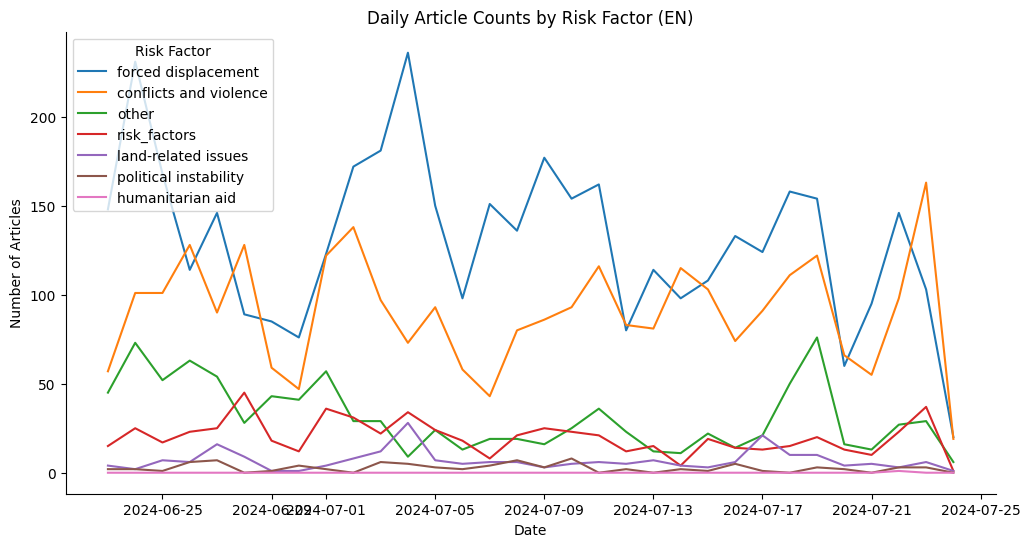

<Figure size 640x480 with 0 Axes>

In [39]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(rf for rfs in df_news_en['risk_factors'] for rf in rfs)

for risk_factor, v in counter.most_common():
    daily_counts = df_news_en['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
    daily_counts.plot(label=risk_factor)

plt.legend(title="Risk Factor")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Risk Factor (EN)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_risk_factor.png", bbox_inches='tight',dpi = 300)

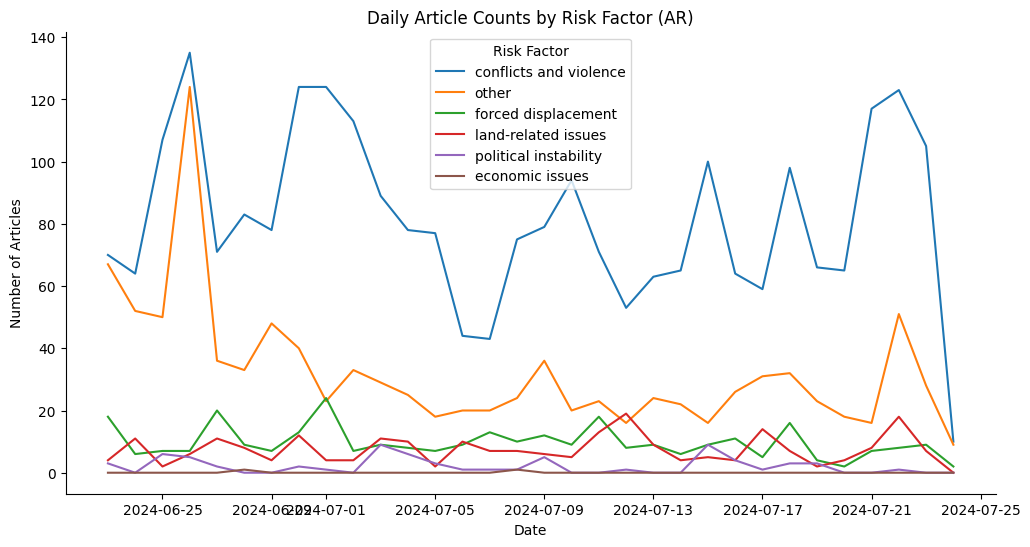

<Figure size 640x480 with 0 Axes>

In [40]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(rf for rfs in df_news_ar['risk_factors'] for rf in rfs)

for risk_factor, v in counter.most_common():
    daily_counts = df_news_ar['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
    daily_counts.plot(label=risk_factor)

plt.legend(title="Risk Factor")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Risk Factor (AR)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_risk_factor_ar.png", bbox_inches='tight',dpi = 300)

The prevalence of different clusters in English and Arabic are quite different. Points to a potential bias if using one source or another or possibly limitations in one or another taxonomy.

## Check out prevalence of countries over time for EN/AR

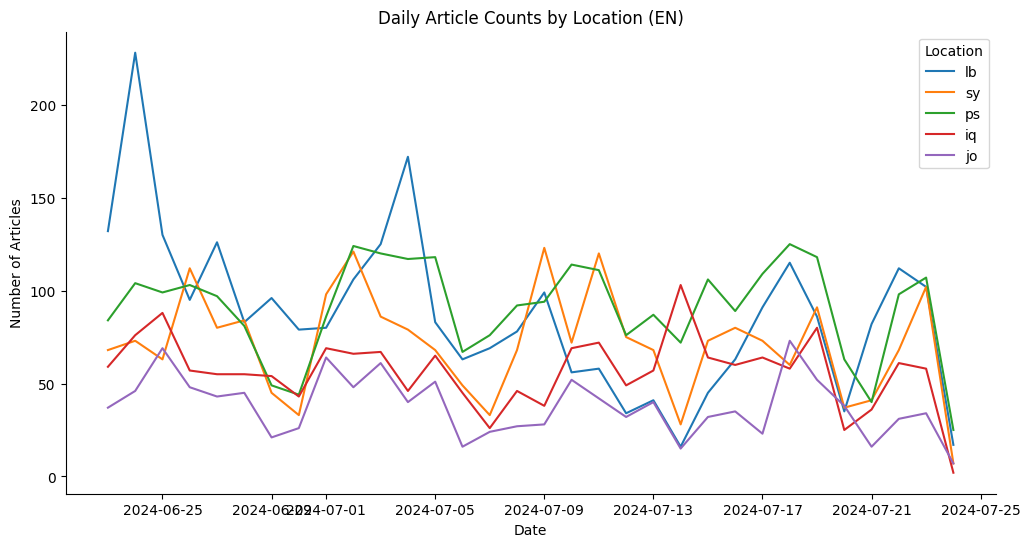

<Figure size 640x480 with 0 Axes>

In [46]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
counter = collections.Counter({k: v for k, v in counter.items() if len(k) == 2})  

# Just look at admin 0 for now

for location, v in counter.most_common():
    daily_counts = df_news_en['locations'].map(lambda rfs: location in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
    daily_counts.plot(label=location)

plt.legend(title="Location")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Location (EN)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_location_en.png", bbox_inches='tight',dpi = 300)

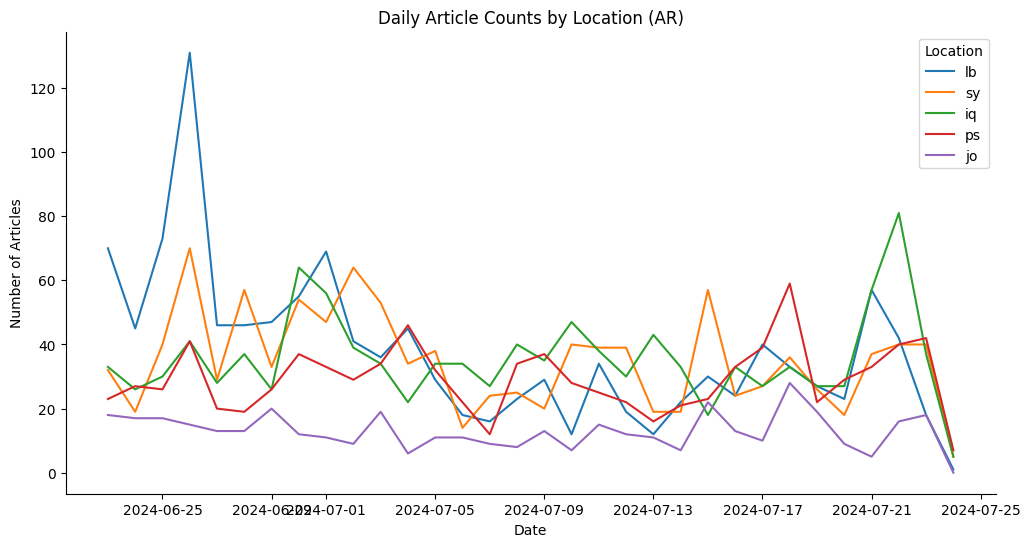

<Figure size 640x480 with 0 Axes>

In [47]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
counter = collections.Counter({k: v for k, v in counter.items() if len(k) == 2})  

# Just look at admin 0 for now

for location, v in counter.most_common():
    daily_counts = df_news_ar['locations'].map(lambda rfs: location in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
    daily_counts.plot(label=location)

plt.legend(title="Location")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Location (AR)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_location_ar.png", bbox_inches='tight',dpi = 300)

# TODO

- Do some simple correltations over time between risk factors and locations EN/AR
- Do a mega multi-plot showing data points in each sub-national area
- Try to get some gorund truth data from e.g. World Bank API